C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\2642869684.py:25: RuntimeWarning: divide by zero encountered in divide
  term = (1 / k) * np.sin((alpha - np.pi) / 2)
C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\2642869684.py:25: RuntimeWarning: invalid value encountered in multiply
  term = (1 / k) * np.sin((alpha - np.pi) / 2)
C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\2642869684.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  term = (1 / k) * np.sin((alpha - np.pi) / 2)
C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\2642869684.py:78: RuntimeWarning: invalid value encountered in scalar multiply
  term = (1 / k) * np.sin((alpha - np.pi) / 2)
C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\2642869684.py:34: RuntimeWarning: invalid value encountered in subtract
  lhs = (K_k - K_sigma0_k)**2


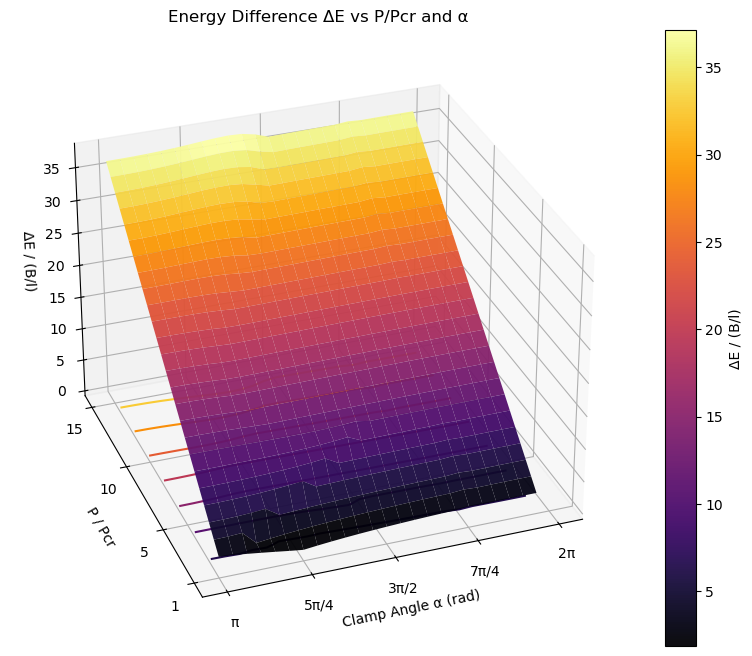

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.special import ellipk, ellipkinc
from scipy.special import ellipk, ellipkinc, ellipj, ellipeinc
from scipy.integrate import solve_ivp


B = 1.0  
l = 1.0 
pi_sq_over_4 = (B * np.pi**2) / (4 * l**2)  
P_cr = pi_sq_over_4  

P_over_Pcr_values = np.linspace(1, 15, 25) 
alpha_values = np.linspace(np.pi, 2 * np.pi, 25)  
s_values = np.linspace(0, l, 100)  
def equilibrium_condition(theta_l, alpha, P_over_Pcr):
    lambda_sq = pi_sq_over_4 * P_over_Pcr  
    k = np.sin((theta_l + alpha - np.pi) / 2)
    
    if np.abs(k) > 1:
        return 1e6  
    term = (1 / k) * np.sin((alpha - np.pi) / 2)
    if np.abs(term) > 1:
        return 1e6  
    sigma0 = np.arcsin(term)
    
  
    K_k = ellipk(k**2)
    K_sigma0_k = ellipkinc(sigma0, k**2)
    
    lhs = (K_k - K_sigma0_k)**2
    P_normalized = P_over_Pcr * P_cr  
    return lhs - P_normalized

def compute_position_corrected(s_values, sigma0, k, lambda_val, l):
    x_values, y_values = [], []
    for s in s_values:
        u = s * lambda_val + ellipkinc(sigma0, k**2)
        cn = ellipj(u, k**2)[1]  
        cn_k = ellipj(ellipkinc(sigma0, k**2), k**2)[1]  
        x = (cn - cn_k) * (-2 * k) / (lambda_val * l)
        am = ellipj(u, k**2)[3]  
        E_am = ellipeinc(am, k**2)  
        E_sigma0 = ellipeinc(sigma0, k**2)  
        y = -(s / l) + (2 / (lambda_val * l)) * (E_am - E_sigma0)
        x_values.append(x)
        y_values.append(y)
    return np.array(x_values), np.array(y_values)

def compute_theta_prime_squared(s_values, x, y):
    dx_ds = np.gradient(x, s_values)
    dy_ds = np.gradient(y, s_values)
    d2x_ds2 = np.gradient(dx_ds, s_values)
    d2y_ds2 = np.gradient(dy_ds, s_values)
    dtheta_ds = (d2y_ds2 * dx_ds - d2x_ds2 * dy_ds) / (dx_ds**2 + dy_ds**2)
    return dtheta_ds**2


energy_results = []
for P_over_Pcr in P_over_Pcr_values:
    energy_alpha = []
    for alpha in alpha_values:
        theta_solutions = []
        for guess in np.linspace(0, 2 * np.pi, 50):
            theta_l_solution, info, ier, mesg = fsolve(equilibrium_condition, guess, args=(alpha, P_over_Pcr), full_output=True)
            if ier == 1:
                theta_l = theta_l_solution[0]
                theta_solutions.append(theta_l)
        unique_solutions = list(set(np.round(theta_solutions, decimals=5)))
        max_energy = -np.inf
        for theta_l in unique_solutions:
            k = np.sin((theta_l + alpha - np.pi) / 2)
            if np.abs(k) > 1:
                continue
            term = (1 / k) * np.sin((alpha - np.pi) / 2)
            sigma0 = np.arcsin(np.clip(term, -1, 1))
            lambda_val = np.sqrt(P_over_Pcr * pi_sq_over_4 / B)
            x, y = compute_position_corrected(s_values, sigma0, k, lambda_val, l)
            theta_prime_squared = compute_theta_prime_squared(s_values, x, y)
            bending_energy = np.trapz(theta_prime_squared, s_values)
            y_l = y[-1]
            total_energy = 0.5 * B * bending_energy + P_over_Pcr * P_cr * np.abs(y_l)
            max_energy = max(max_energy, total_energy)
        energy_alpha.append(max_energy / (B / l))
    energy_results.append(energy_alpha)


energy_results = np.array(energy_results)


P, A = np.meshgrid(P_over_Pcr_values, alpha_values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(A, P, energy_results.T, cmap=cm.inferno, edgecolor='none', antialiased=True, alpha=0.95)

contour = ax.contour(A, P, energy_results.T, zdir='z', offset=0, cmap=cm.inferno, linewidths=1.5)


ax.set_xlabel('Clamp Angle α (rad)')
ax.set_ylabel('P / Pcr')
ax.set_zlabel('ΔE / (B/l)')
ax.set_xticks([np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4, 2*np.pi])
ax.set_xticklabels(['π', '5π/4', '3π/2', '7π/4', '2π'])
ax.set_yticks([1, 5, 10, 15])
ax.set_zlim(0, np.max(energy_results))
ax.view_init(elev=30, azim=250)

plt.title('Energy Difference ΔE vs P/Pcr and α')

plt.colorbar(surf, label='ΔE / (B/l)')
plt.savefig('Fig11a.pdf')
plt.show()


C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\3305933454.py:25: RuntimeWarning: divide by zero encountered in divide
  term = (1 / k) * np.sin((alpha - np.pi) / 2)
C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\3305933454.py:25: RuntimeWarning: invalid value encountered in multiply
  term = (1 / k) * np.sin((alpha - np.pi) / 2)
C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\3967934901.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  term = (1 / k) * np.sin((alpha - np.pi) / 2)
C:\Users\Mohan Raj A\AppData\Local\Temp\ipykernel_23936\3967934901.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  term = (1 / k) * np.sin((alpha - np.pi) / 2)


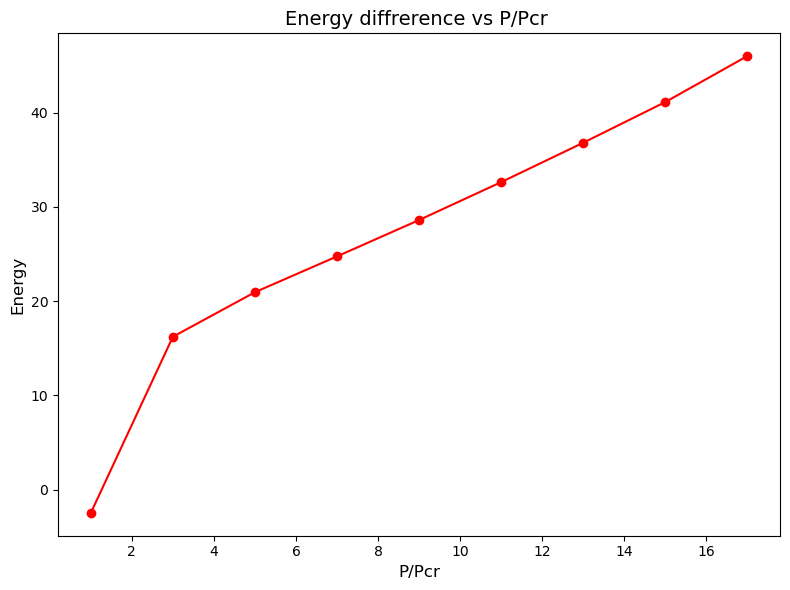

In [ ]:

energy_values = []
initial_guesses=np.linspace(0,2*np.pi,20)
P_over_Pcr_values = [1,3, 5, 7, 9, 11, 13, 15, 17]
alpha_div_pi_values = [1,1.34849, 1.57630, 1.70252,  5.58999/np.pi, 1.83039, 1.86611, 1.89194, 1.9]
alpha_div_pi_values=np.array(alpha_div_pi_values)

for P_over_Pcr, alpha_div_pi in zip(P_over_Pcr_values, alpha_div_pi_values):
    alpha = alpha_div_pi * np.pi  
    theta_solutions = []

    for guess in initial_guesses:
        theta_l_solution, info, ier, mesg = fsolve(equilibrium_condition, guess, args=(alpha, P_over_Pcr), full_output=True)
        if ier == 1:
            theta_l = theta_l_solution[0]
            theta_solutions.append(theta_l)
    
    unique_solutions = list(set(np.round(theta_solutions, decimals=5)))
    max_energy = -np.inf  

    for theta_l in unique_solutions:
        k = np.sin((theta_l + alpha - np.pi) / 2)
        term = (1 / k) * np.sin((alpha - np.pi) / 2)
        sigma0 = np.arcsin(np.clip(term, -1, 1))
        lambda_val = np.sqrt(P_over_Pcr * pi_sq_over_4 / B)
        x, y = compute_position_corrected(s_values, sigma0, k, lambda_val, l)
        
 
        energy = (2 * x[-1] + np.cos(theta_l + alpha)) * ((np.pi**2) / 4) * P_over_Pcr
        max_energy = max(max_energy, energy) 
    
    energy_values.append(max_energy)

plt.figure(figsize=(8, 6))
plt.plot(P_over_Pcr_values, energy_values, marker='o', color='red', label='Energy vs P/Pcr')
plt.xlabel('P/Pcr', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.title('Energy diffrerence vs P/Pcr ', fontsize=14)
# plt.grid(True)
plt.savefig('Fig11b.pdf')
# plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


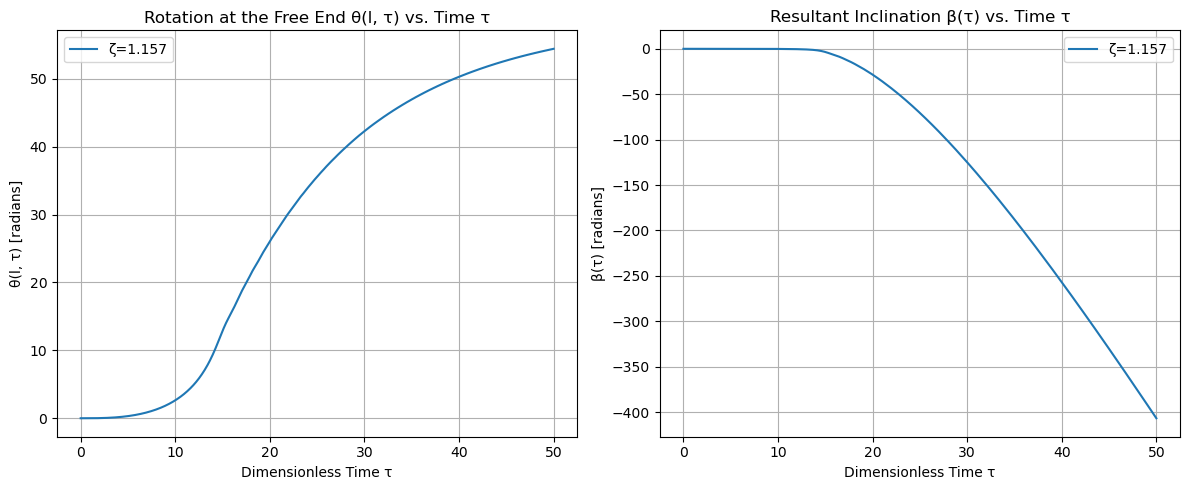

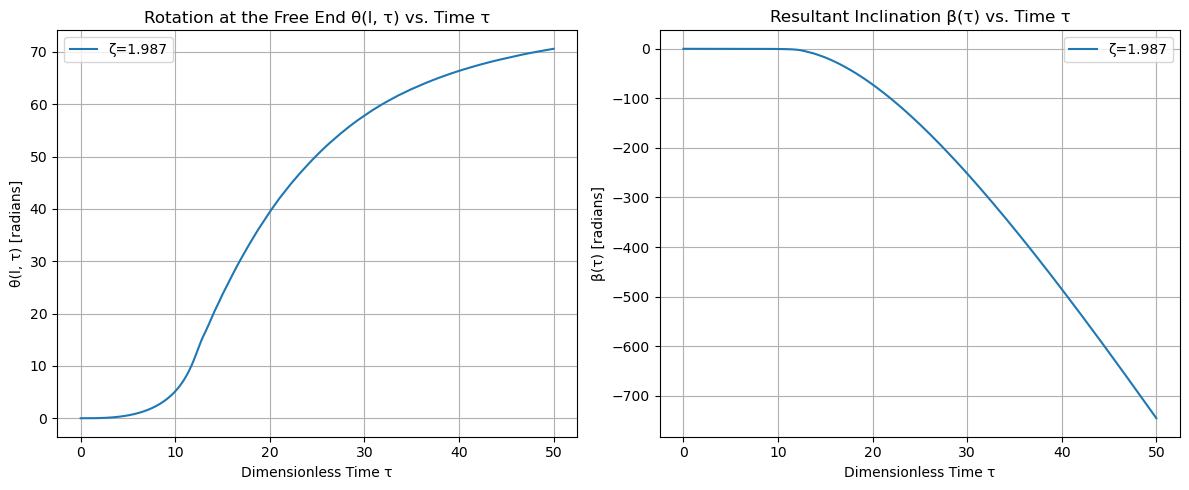

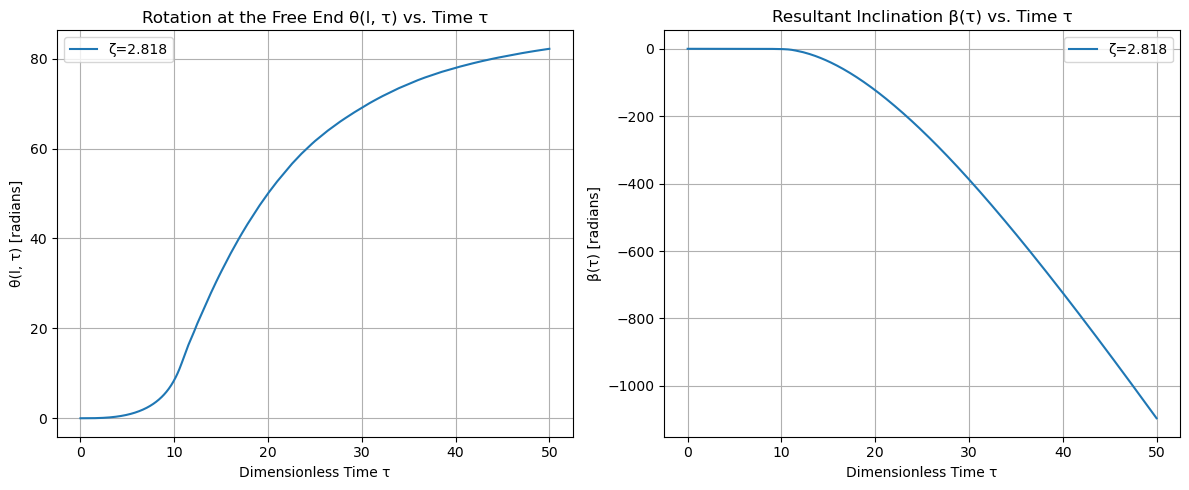

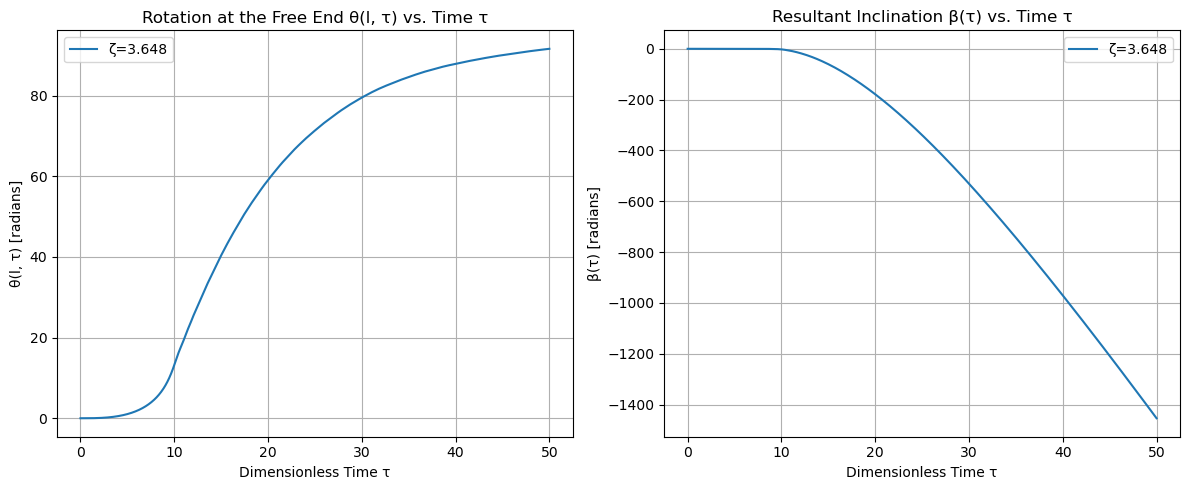

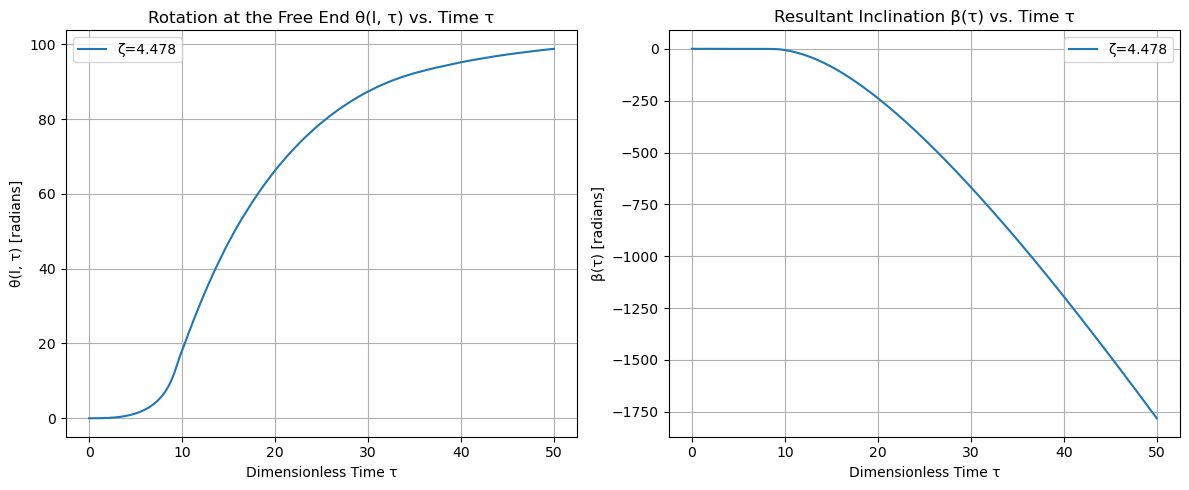

In [ ]:


omega = 0.014            
nu = 0.069               
kappa_c = 310.647       
Omega = omega          


zeta_values = [1.157, 1.987, 2.818, 3.648, 4.478]  

alpha0 = 1e-5            

tau_start = 0.0
tau_end = 50.0
tau_eval = np.linspace(tau_start, tau_end, 1000)

def dynamics(tau, y, zeta):
    theta_l, beta, dtheta_l_dtau, dbeta_dtau = y

    alpha_tau = alpha0 + Omega * tau

    mu_tau = zeta

    delta_alpha_beta = alpha_tau - beta

    ddtheta_l_dtau2 = mu_tau * np.sin(delta_alpha_beta) - nu * dtheta_l_dtau
    ddbeta_dtau2 = mu_tau * np.cos(delta_alpha_beta) - zeta - nu * dbeta_dtau

    return [dtheta_l_dtau, dbeta_dtau, ddtheta_l_dtau2, ddbeta_dtau2]


for zeta in zeta_values:

    theta_l0 = 0.0
    beta0 = alpha0
    dtheta_l_dtau0 = 0.0
    dbeta_dtau0 = 0.0
    y0 = [theta_l0, beta0, dtheta_l_dtau0, dbeta_dtau0]


    sol = solve_ivp(dynamics, [tau_start, tau_end], y0, args=(zeta,), t_eval=tau_eval, method='RK45')


    tau = sol.t
    theta_l = sol.y[0]
    beta = sol.y[1]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(tau, theta_l, label=f'ζ={zeta}')
    plt.xlabel('Dimensionless Time τ')
    plt.ylabel('θ(l, τ) [radians]')
    plt.title('Rotation at the Free End θ(l, τ) vs. Time τ')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(tau, beta, label=f'ζ={zeta}')
    plt.xlabel('Dimensionless Time τ')
    plt.ylabel('β(τ) [radians]')
    plt.title('Resultant Inclination β(τ) vs. Time τ')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Solver did not converge for alpha = 2.792526803190927 and lambda = 2.8177720565110116
Solver did not converge for alpha = 3.236792430971302 and lambda = 2.8177720565110116
Solver did not converge for alpha = 2.6021272484279097 and lambda = 3.64928622730279
Solver did not converge for alpha = 2.6655937666822487 and lambda = 3.64928622730279
Solver did not converge for alpha = 2.792526803190927 and lambda = 3.64928622730279
Solver did not converge for alpha = 2.8559933214452666 and lambda = 3.64928622730279
Solver did not converge for alpha = 3.42719198573432 and lambda = 3.64928622730279
Solver did not converge for alpha = 3.490658503988659 and lambda = 3.64928622730279
Solver did not converge for alpha = 3.6175915404973376 and lambda = 3.64928622730279
Solver did not converge for alpha = 1.6501294746128208 and lambda = 19.233391576622886


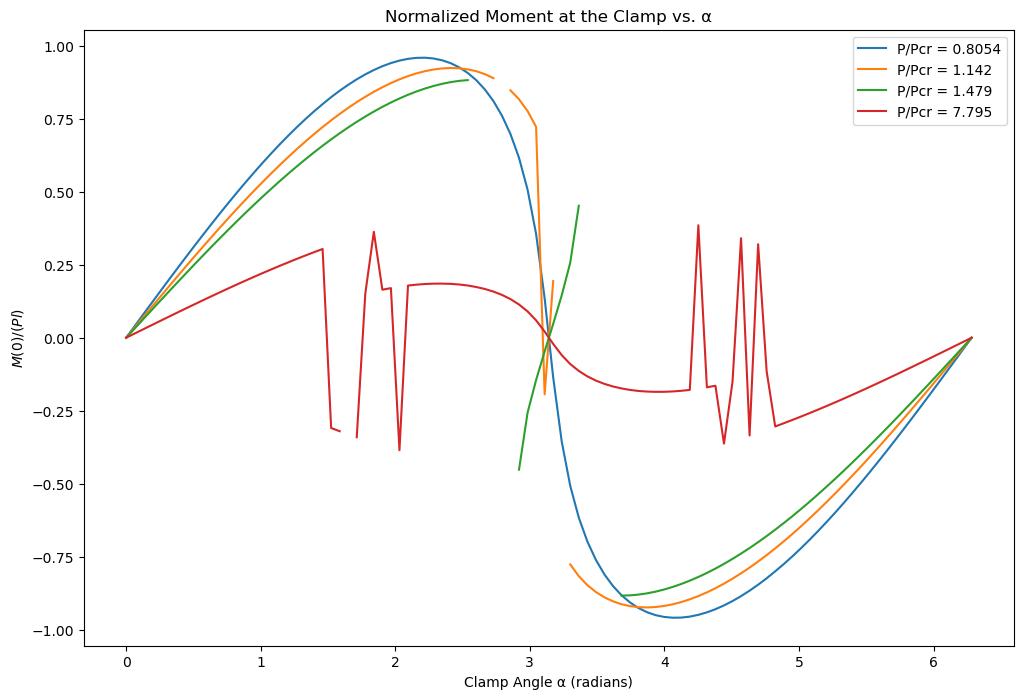

In [5]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Rod properties
E = 2.35e9           # Young's Modulus (Pa)
I = 5.625e-11        # Moment of inertia (m^4)
B = E * I            # Bending stiffness (Nm^2)
l = 0.345            # Length of the rod (m)
P_cr = (np.pi**2 * B) / (4 * l**2)  # Critical load (N)

# P/P_cr values
P_over_Pcr_values = [0.8054, 1.142, 1.479,7.795]

# Compute corresponding P and lambda values
lambda_values = []
for P_over_Pcr in P_over_Pcr_values:
    P = P_over_Pcr * P_cr
    lambda_val = (P * l**2) / B
    lambda_values.append(lambda_val)

# Define the ODE system
def elastica_ode(s, y, lambda_val, alpha):
    theta = y[0]
    phi = y[1]
    dtheta_ds = phi
    dphi_ds = lambda_val * np.sin(theta + alpha)
    return np.vstack((dtheta_ds, dphi_ds))

# Boundary conditions
def bc(ya, yb):
    theta_a, phi_a = ya
    theta_b, phi_b = yb
    return np.array([theta_a, phi_b])  # theta(0) = 0, phi(1) = 0

# Define s domain
s = np.linspace(0, 1, 100)  # s' from 0 to 1

# Range of alpha values
alpha_values = np.linspace(0, 2 * np.pi, 100)

# Plotting
plt.figure(figsize=(12, 8))

for idx, lambda_val in enumerate(lambda_values):
    M0_over_Pl_values = []
    for alpha in alpha_values:
        # Initial guess for y = [theta(s), phi(s)]
        y_init = np.zeros((2, s.size))
        
        # Solve the BVP
        sol = solve_bvp(lambda s, y: elastica_ode(s, y, lambda_val, alpha), bc, s, y_init, max_nodes=10000)
        
        if sol.status != 0:
            print(f"Solver did not converge for alpha = {alpha} and lambda = {lambda_val}")
            M0_over_Pl_values.append(np.nan)
            continue
        
        # Extract theta'(0)
        phi0 = sol.y[1][0]
        
        # Compute M(0)/(P l) = theta'(0) / lambda
        M0_over_Pl = -phi0 / lambda_val
        M0_over_Pl_values.append(M0_over_Pl)
    
    # Convert to numpy array
    M0_over_Pl_values = np.array(M0_over_Pl_values)
    
    # Plot
    plt.plot(alpha_values, M0_over_Pl_values, label=f'P/Pcr = {P_over_Pcr_values[idx]}')
    
plt.xlabel('Clamp Angle α (radians)')
plt.ylabel(r'$M(0)/(P l)$')
plt.title('Normalized Moment at the Clamp vs. α')
plt.savefig('Fig14.pdf')
# plt.grid(True)
plt.legend()
plt.show()
